# Analyzing the behaviour of various factors related to COVID for the state of New York

In [15]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import figure
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as cx
import mapclassify
import warnings

In [2]:
path = '../data/'

In [3]:
# read the main dataset

data = pd.read_parquet(path+'processed_datasets/final_dataset_v3.parquet')

In [4]:
data.head(2)

,index,county,date,daily_cases,daily_deaths,POP2020,Partially Vaccinated,Fully Vaccinated,Non Vaccinated,Partially Vaccinated per Population,...,Number of ICU Beds By County,Number of ICU Beds Available By County,Total Beds By County per thousand ppl,Number of ICU Beds By County per thousand ppl,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,0,Albany,2020-03-26,19.0,0.0,314848,0.0,0.0,0.0,0.0,...,80.0,43.0,3.795482,0.254091,-51.0,-11.0,43.0,-53.0,-55.0,23.0
1,110535,Suffolk,2020-03-26,475.0,2.0,1524665,0.0,0.0,0.0,0.0,...,309.0,68.0,1.737431,0.202667,-44.0,-14.0,122.0,-63.0,-53.0,24.0


In [5]:
# Data Preprocessing

df = data[['county', 'date', 'daily_cases', 'daily_deaths', 'Fully Vaccinated per Population', 'Patients Currently Hospitalized', 'POP2020']]
df = df.groupby(['county', 'date', 'daily_cases', 'daily_deaths', 
                  'Fully Vaccinated per Population', 'POP2020'])['Patients Currently Hospitalized'].sum().reset_index()

In [6]:
# Create per population columns

df['daily_cases_by_population'] = df.apply(lambda x: x['daily_cases']/x['POP2020'], axis=1)
df['daily_deaths_by_population'] = df.apply(lambda x: x['daily_deaths']/x['POP2020'], axis=1)
df['hospitalizations_by_population'] = df.apply(lambda x: x['Patients Currently Hospitalized']/x['POP2020'], axis=1)

In [7]:
df = df.rename(columns={'Fully Vaccinated per Population':'fully_vacc_by_pop', 
                'Patients Currently Hospitalized':'patients_curr_hosp',
                'hospitalizations_by_population':'hosp_by_pop'})
df.head(1)

,county,date,daily_cases,daily_deaths,fully_vacc_by_pop,POP2020,patients_curr_hosp,daily_cases_by_population,daily_deaths_by_population,hosp_by_pop
0,Albany,2020-03-26,19.0,0.0,0.0,314848,22.0,0.00006,0.0,0.00007


In [9]:
# this file is used to get the geometry for counties, so that they can be plotted on a map

street_map = gpd.read_file(path+'raw_datasets/NYS_Civil_Boundaries.shp.zip')

In [10]:
street_map = street_map.rename(columns={'COUNTY':'county'})
street_map.head(1)

,NAME,MUNI_TYPE,MUNITYCODE,county,GNIS_ID,FIPS_CODE,SWIS,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,MAP_SYMBOL,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
0,Adams,town,2,Jefferson,978655,3604500210,222000,4977,4782,5143,4973,None,None,T,42.361757,2018-11-06,41971.838963,1.097164e+08,"POLYGON ((419711.937 4860894.762, 420725.148 4..."


In [11]:
%matplotlib inline

In [12]:
# function to create a map of New York counties and plot values on that

def plot_geo_data(df, col_name, ax, fig, title="", show_base_cbar=False, show_base_map=False):
    k = 1600
    cmap = 'YlGnBu'
    figsize = (20, 15)
    scheme = 'Quantiles'
    crs = {'init': 'epsg:4326'}

    subset = df.copy()

    subset = subset.to_crs(crs)
    subset.plot(column=col_name, cmap=cmap, figsize=figsize, ax=ax,
                scheme=scheme, k=k, legend=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Adding Colorbar for legibility

    # normalize color
    vmin, vmax, vcenter = subset[col_name].min(), subset[col_name].max(), subset[col_name].mean()
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    # create a normalized colorbar
    if show_base_cbar:
        cbar = plt.cm.ScalarMappable(norm=divnorm, cmap=cmap)
        fig.colorbar(cbar, ax=ax)
    ax.set(title=title,
           ylabel="Latitude", xlabel="Longitude")
    if show_base_map:
        cx.add_basemap(ax, crs=crs, source=cx.providers.Stamen.TonerLite)


## Did the number of cases, deaths and hospitalisation decrease in counties which had higher vaccine rates?

### Plots of cases, deaths, hospitalization while comparing them to vaccination for different counties over different time periods.

Since cases, deaths, hospitalisation and vaccination cannot be compared to each other for the same date, we've taken a set of dates to analyze the behaviour. We've taken the death date from the peak of different waves. The date from one week before death is assumed to be the hospitalization date, two weeks before death is date of case and four weeks before is taken as vaccination. 

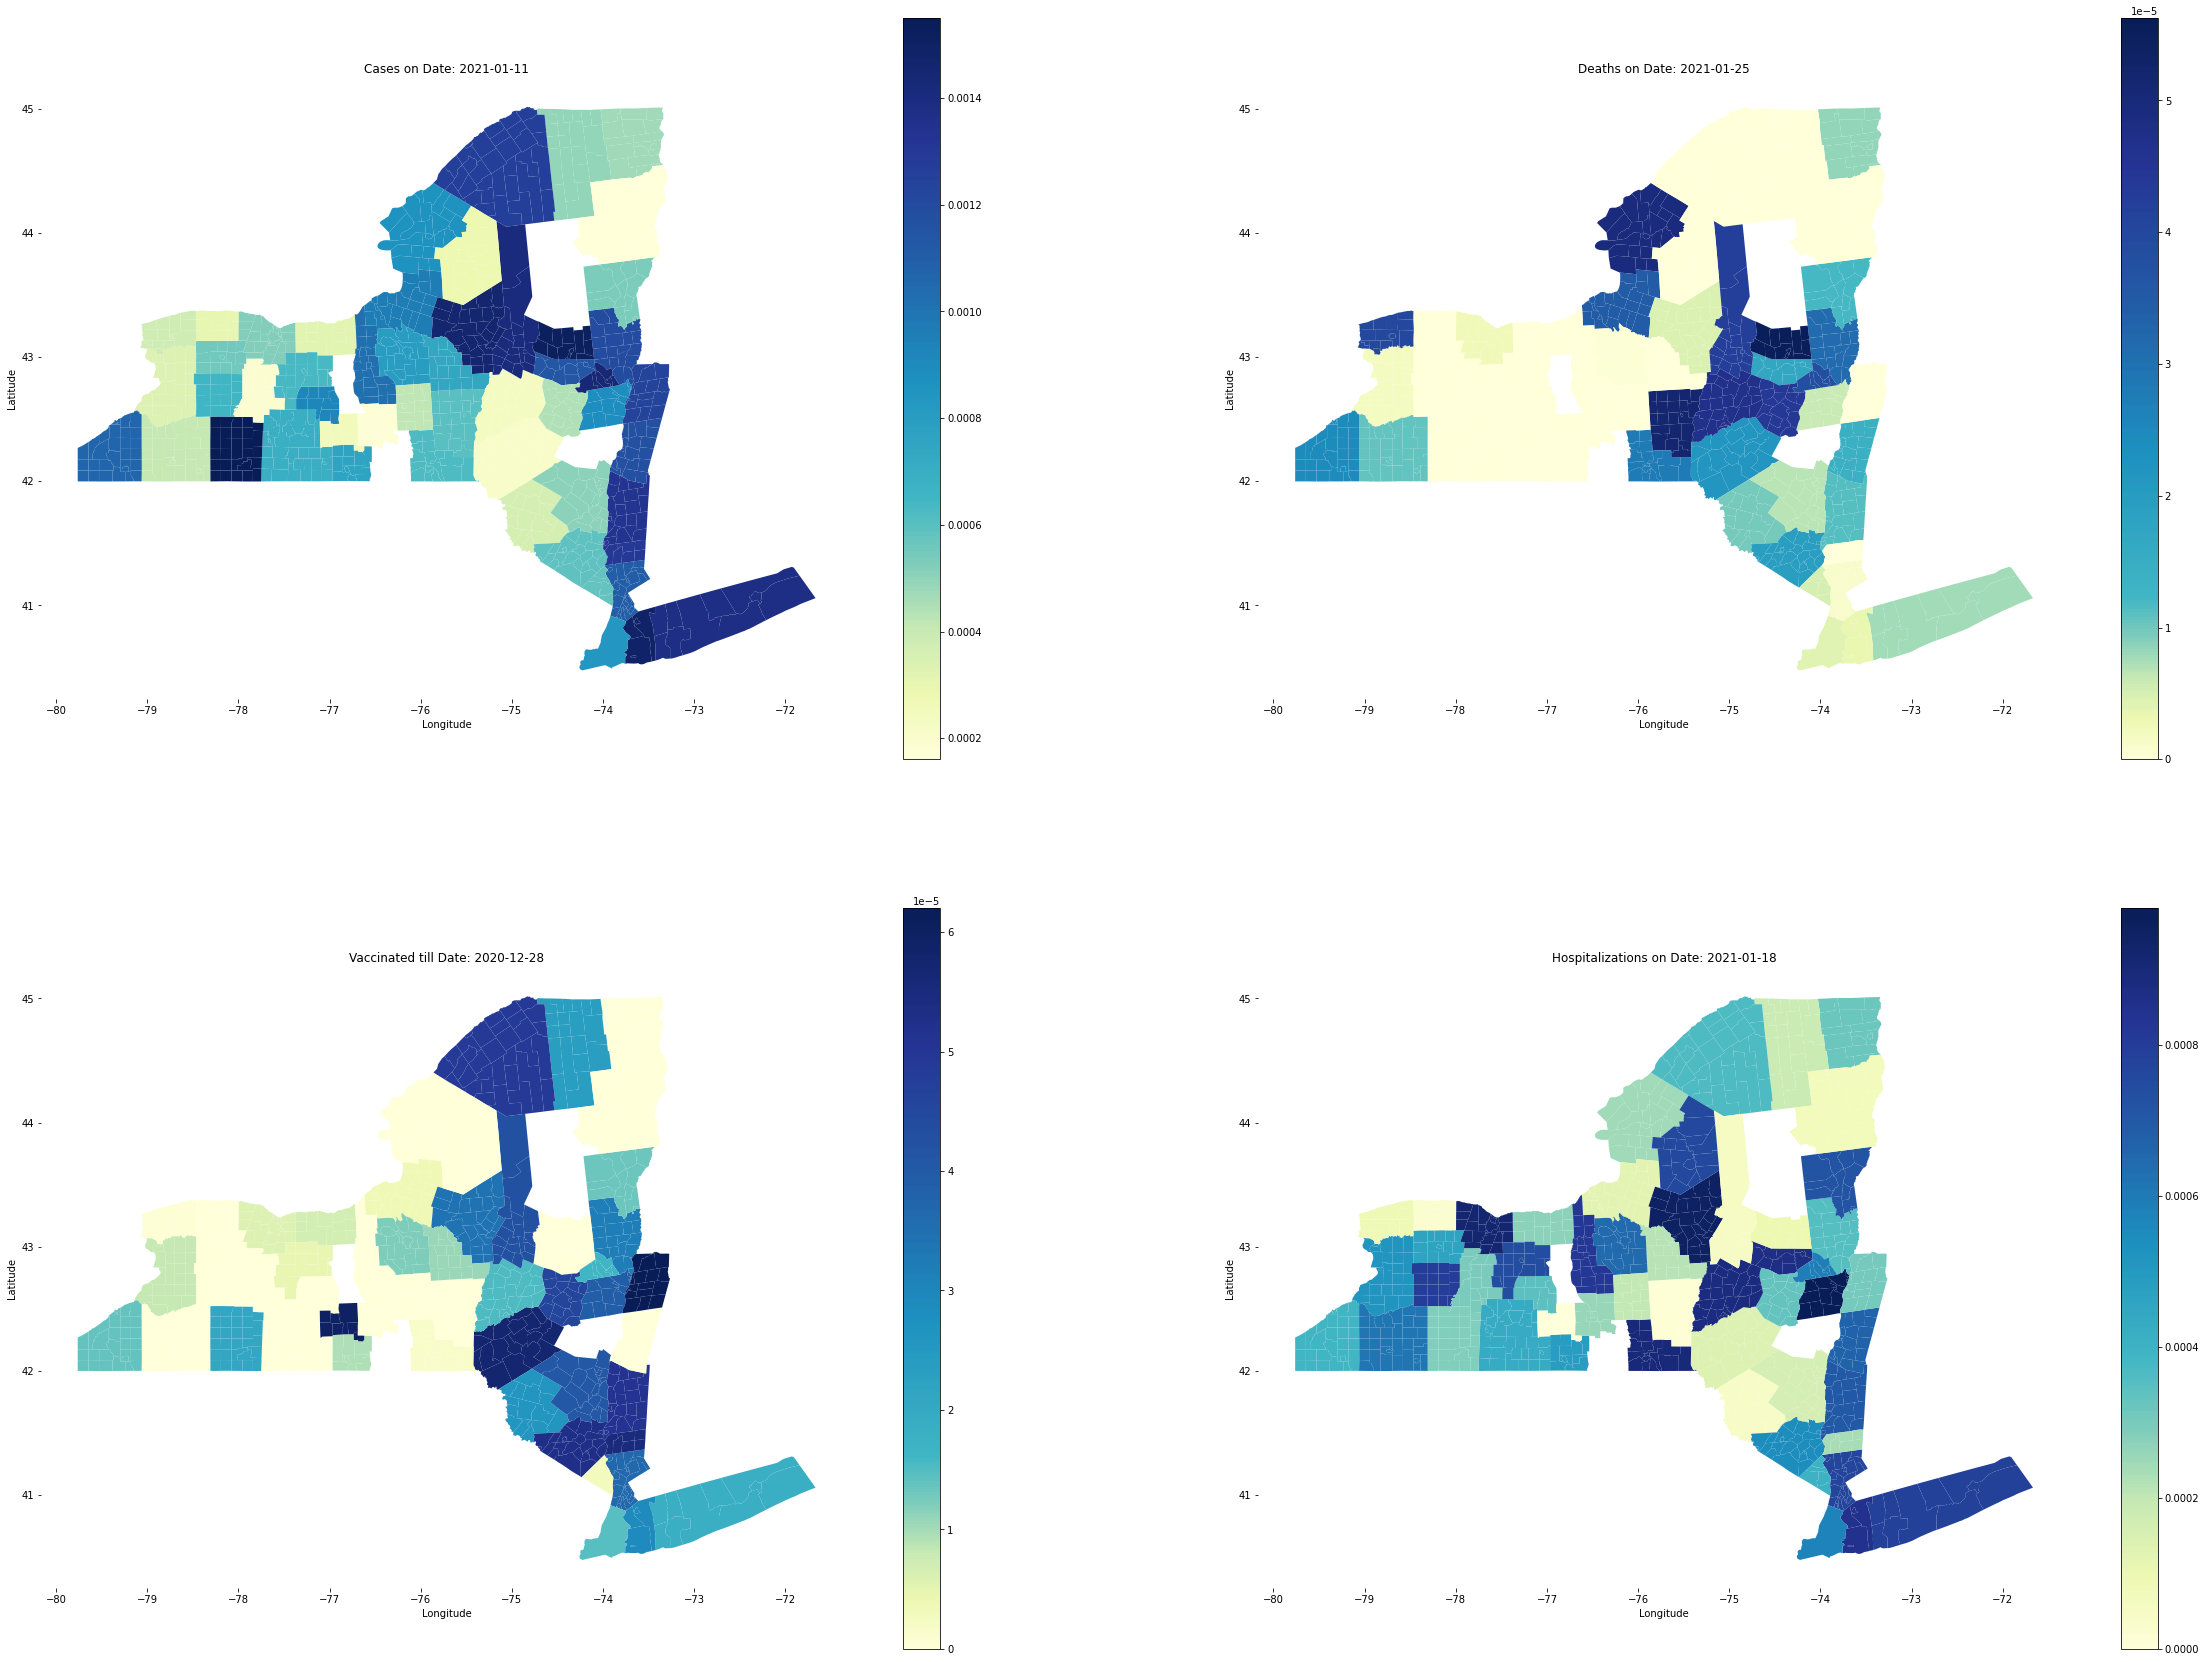

In [17]:
# Third wave. This was also the period when people had just started receiving their first dose of vaccines.

warnings.filterwarnings('ignore')

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(40,30), ncols=2,nrows=2)

for date,ax in [('2021-01-11',ax1)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_cases_by_population', ax=ax, fig=fig, title="Cases on Date: "+date, show_base_cbar=True)

for date,ax in [('2021-01-25',ax2)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_deaths_by_population', ax=ax, fig=fig, title="Deaths on Date: "+date, show_base_cbar=True)

for date,ax in [('2020-12-28',ax3)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'fully_vacc_by_pop', ax=ax, fig=fig, title="Vaccinated till Date: "+date, show_base_cbar=True)

for date,ax in [('2021-01-18',ax4)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'hosp_by_pop', ax=ax, fig=fig, title="Hospitalizations on Date: "+date, show_base_cbar=True)

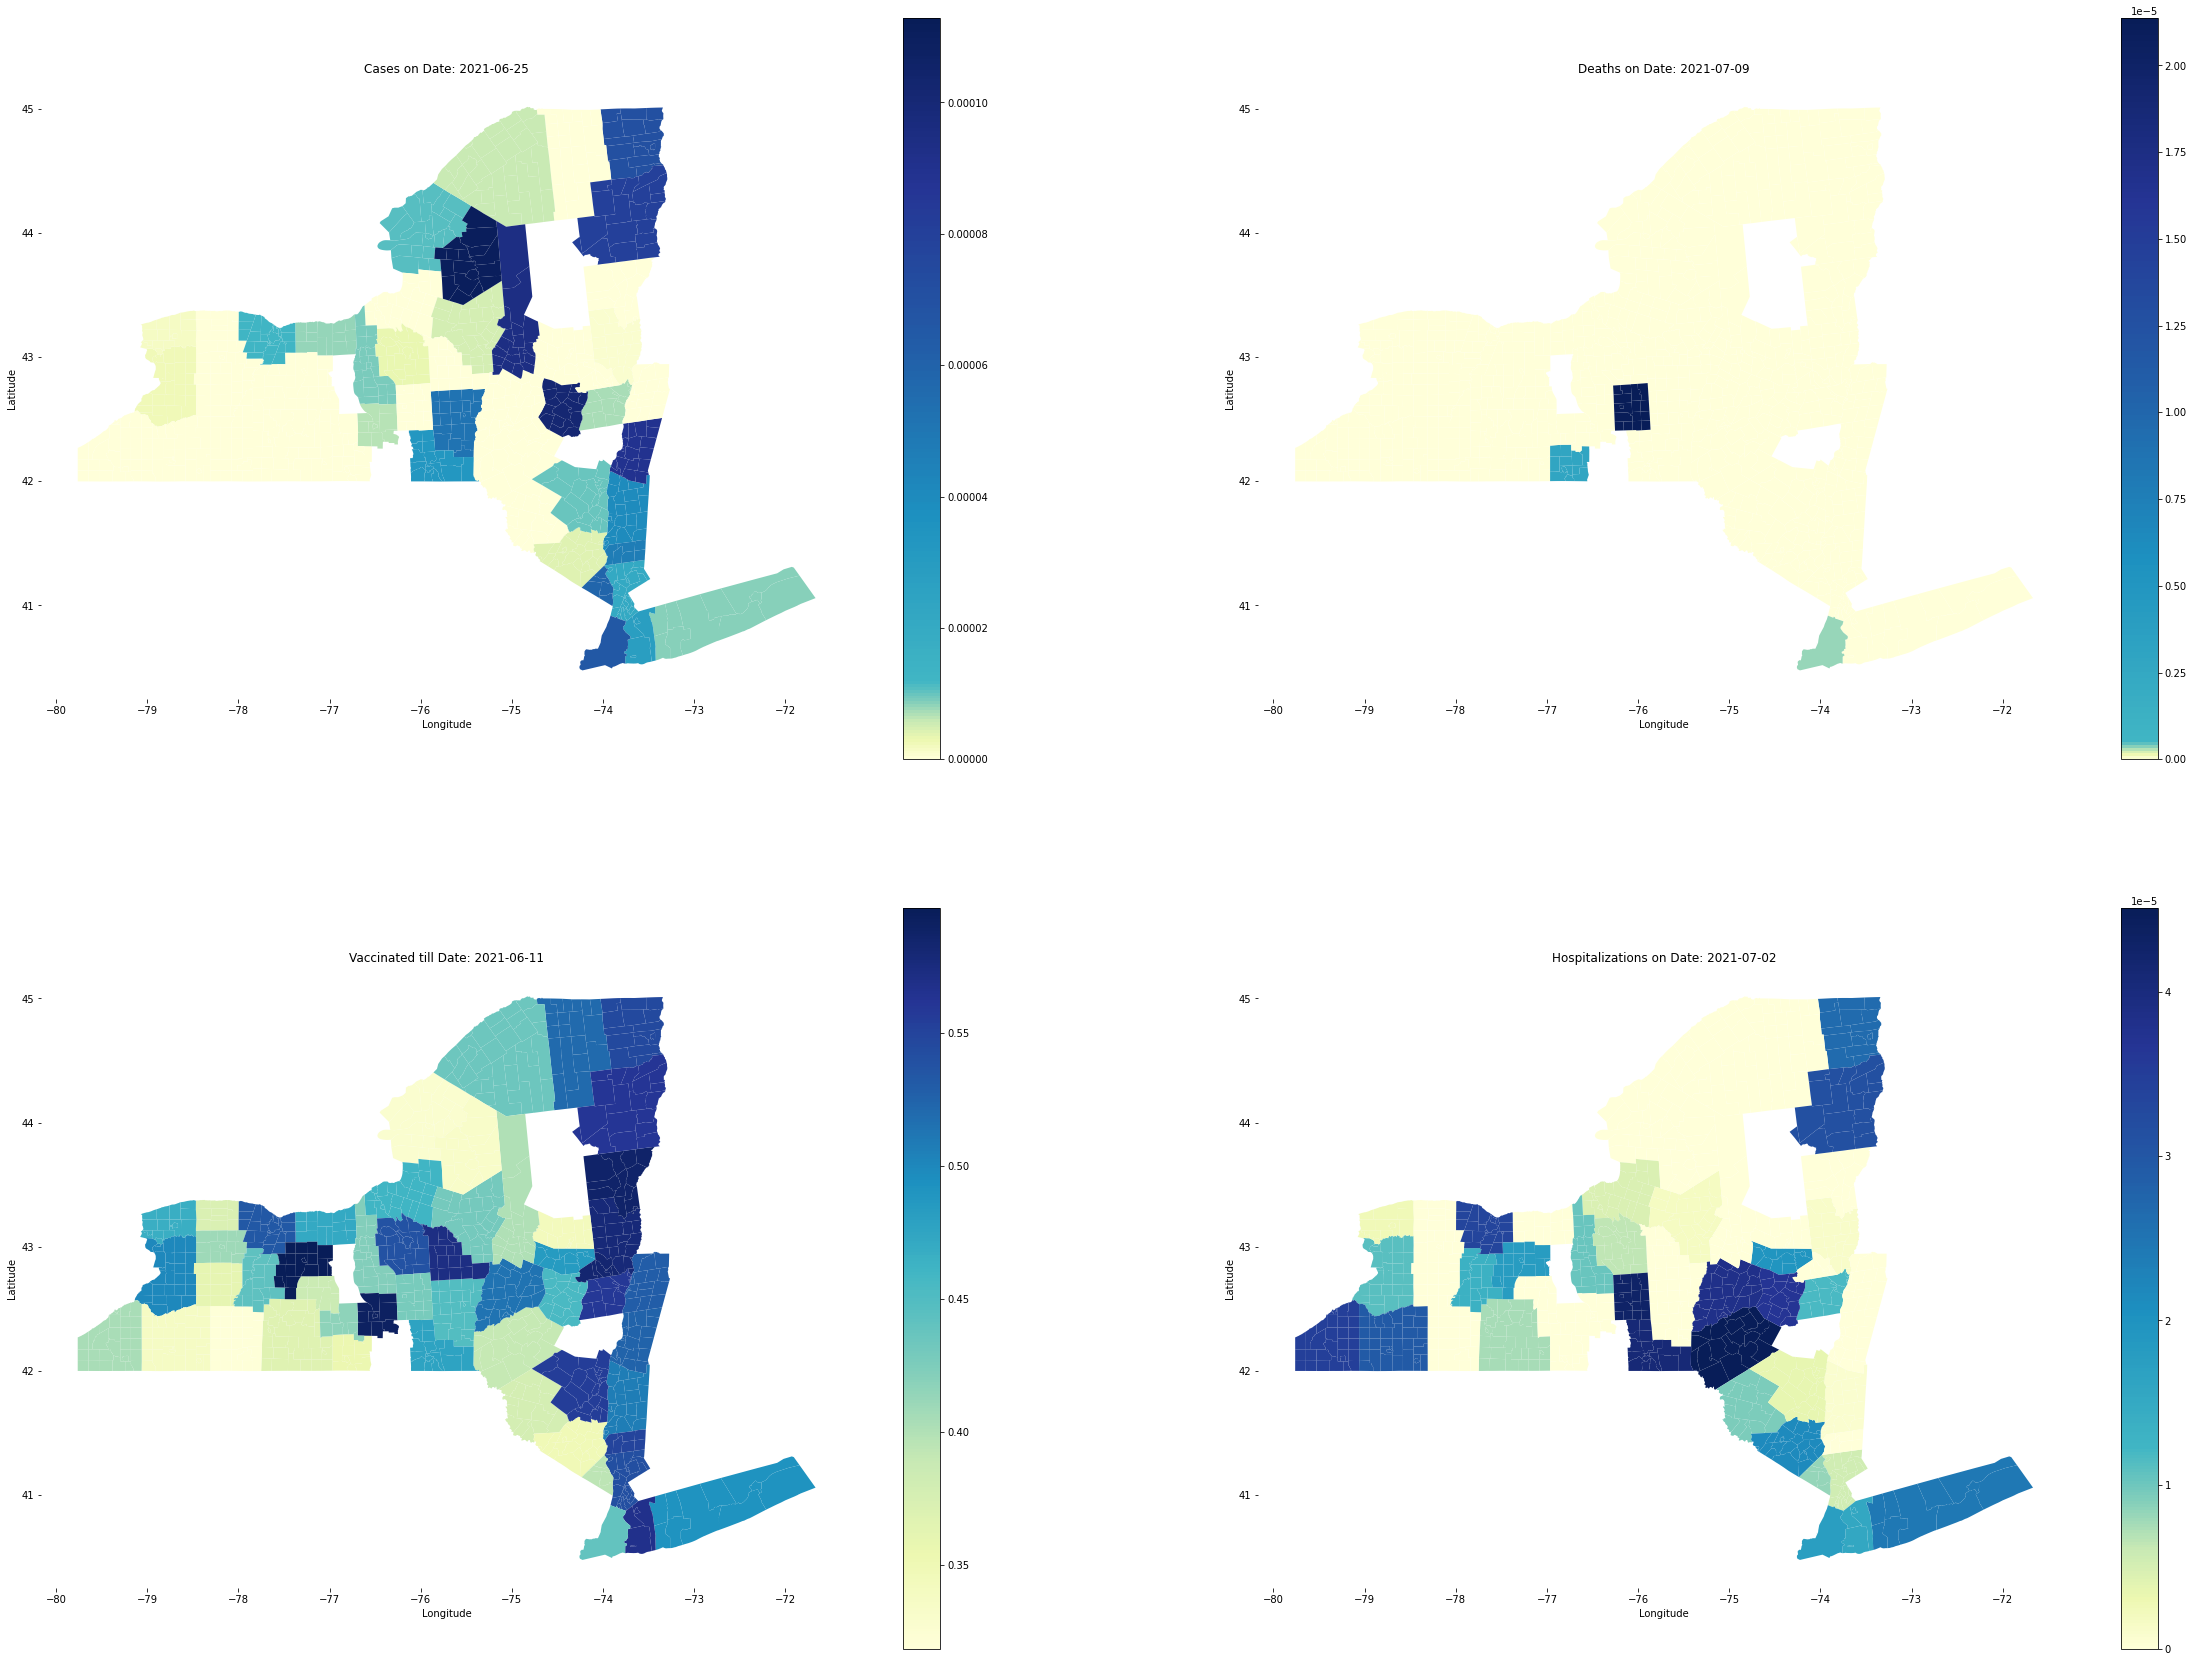

In [18]:
# Spring/Summer season. There weren't a lot of cases and very few deaths during this period.

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(40,30), ncols=2,nrows=2)

for date,ax in [('2021-06-25',ax1)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_cases_by_population', ax=ax, fig=fig, title="Cases on Date: "+date, show_base_cbar=True)

for date,ax in [('2021-07-09',ax2)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_deaths_by_population', ax=ax, fig=fig, title="Deaths on Date: "+date, show_base_cbar=True)

for date,ax in [('2021-06-11',ax3)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'fully_vacc_by_pop', ax=ax, fig=fig, title="Vaccinated till Date: "+date, show_base_cbar=True)

for date,ax in [('2021-07-02',ax4)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'hosp_by_pop', ax=ax, fig=fig, title="Hospitalizations on Date: "+date, show_base_cbar=True)

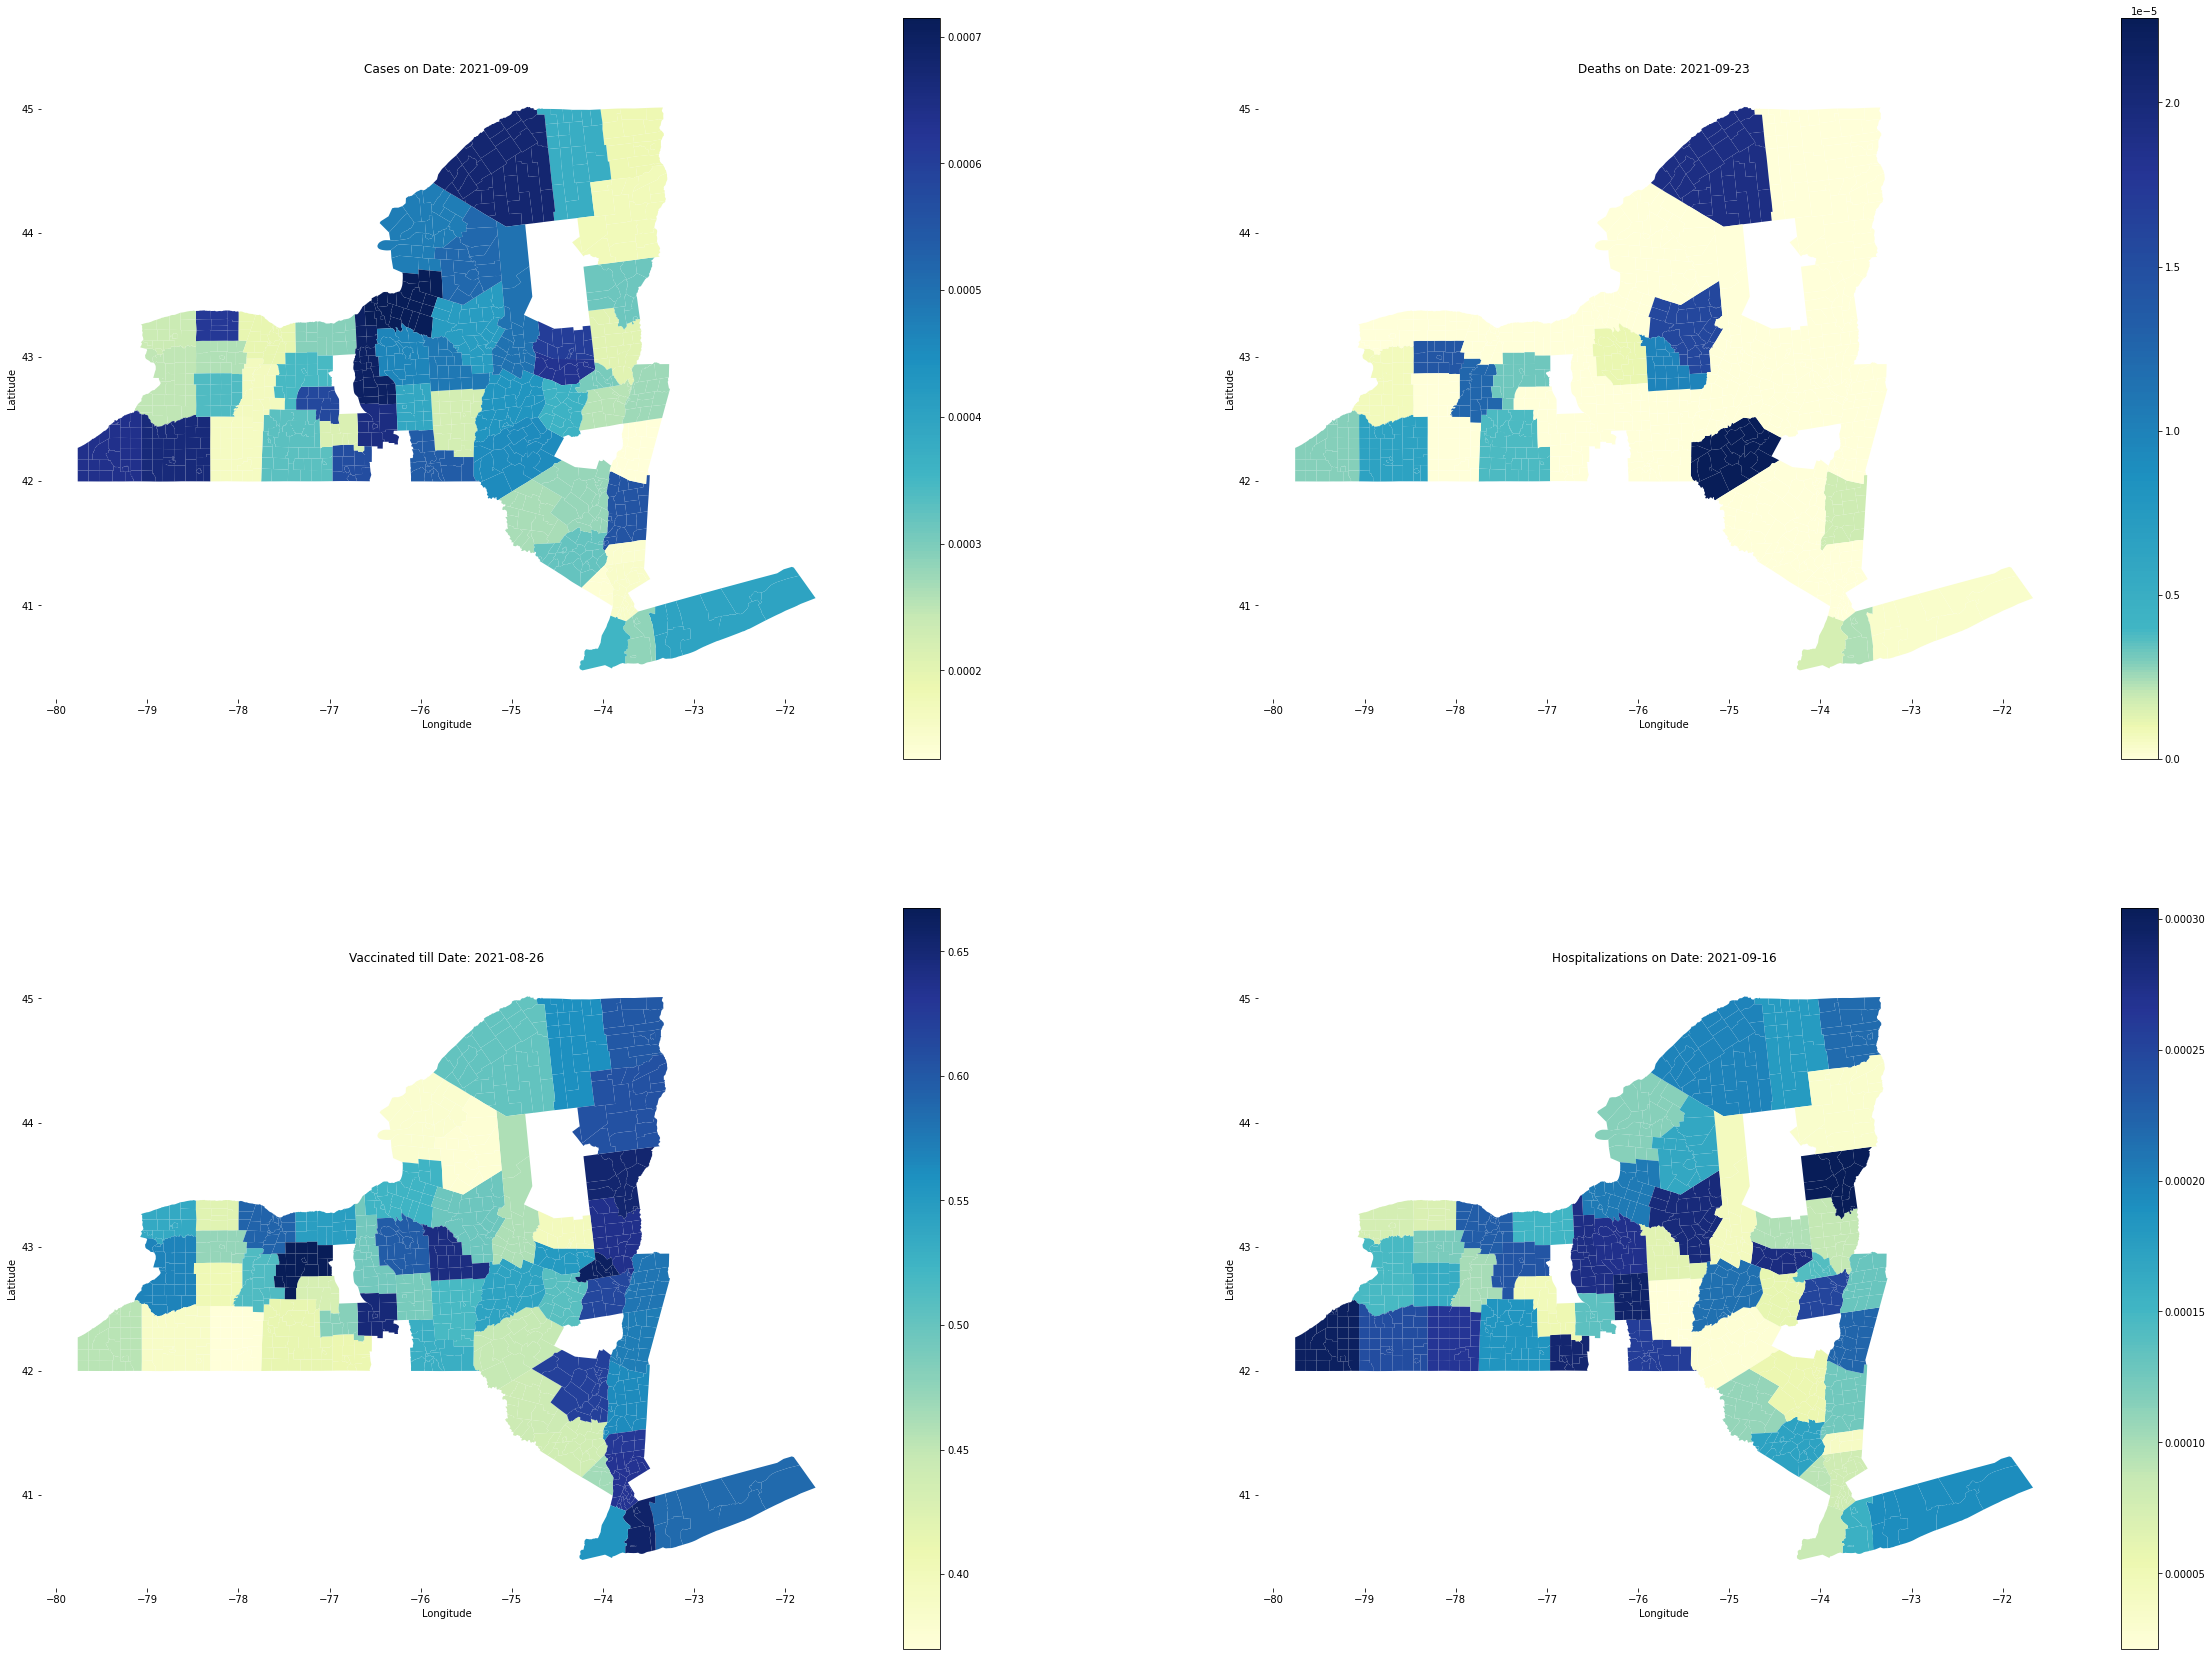

In [28]:
# Fourth Wave - Delta variant

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(40,30), ncols=2,nrows=2)

for date,ax in [('2021-09-09',ax1)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_cases_by_population', ax=ax, fig=fig, title="Cases on Date: "+date, show_base_cbar=True)

for date,ax in [('2021-09-23',ax2)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_deaths_by_population', ax=ax, fig=fig, title="Deaths on Date: "+date, show_base_cbar=True)

for date,ax in [('2021-08-26',ax3)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'fully_vacc_by_pop', ax=ax, fig=fig, title="Vaccinated till Date: "+date, show_base_cbar=True)

for date,ax in [('2021-09-16',ax4)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'hosp_by_pop', ax=ax, fig=fig, title="Hospitalizations on Date: "+date, show_base_cbar=True)

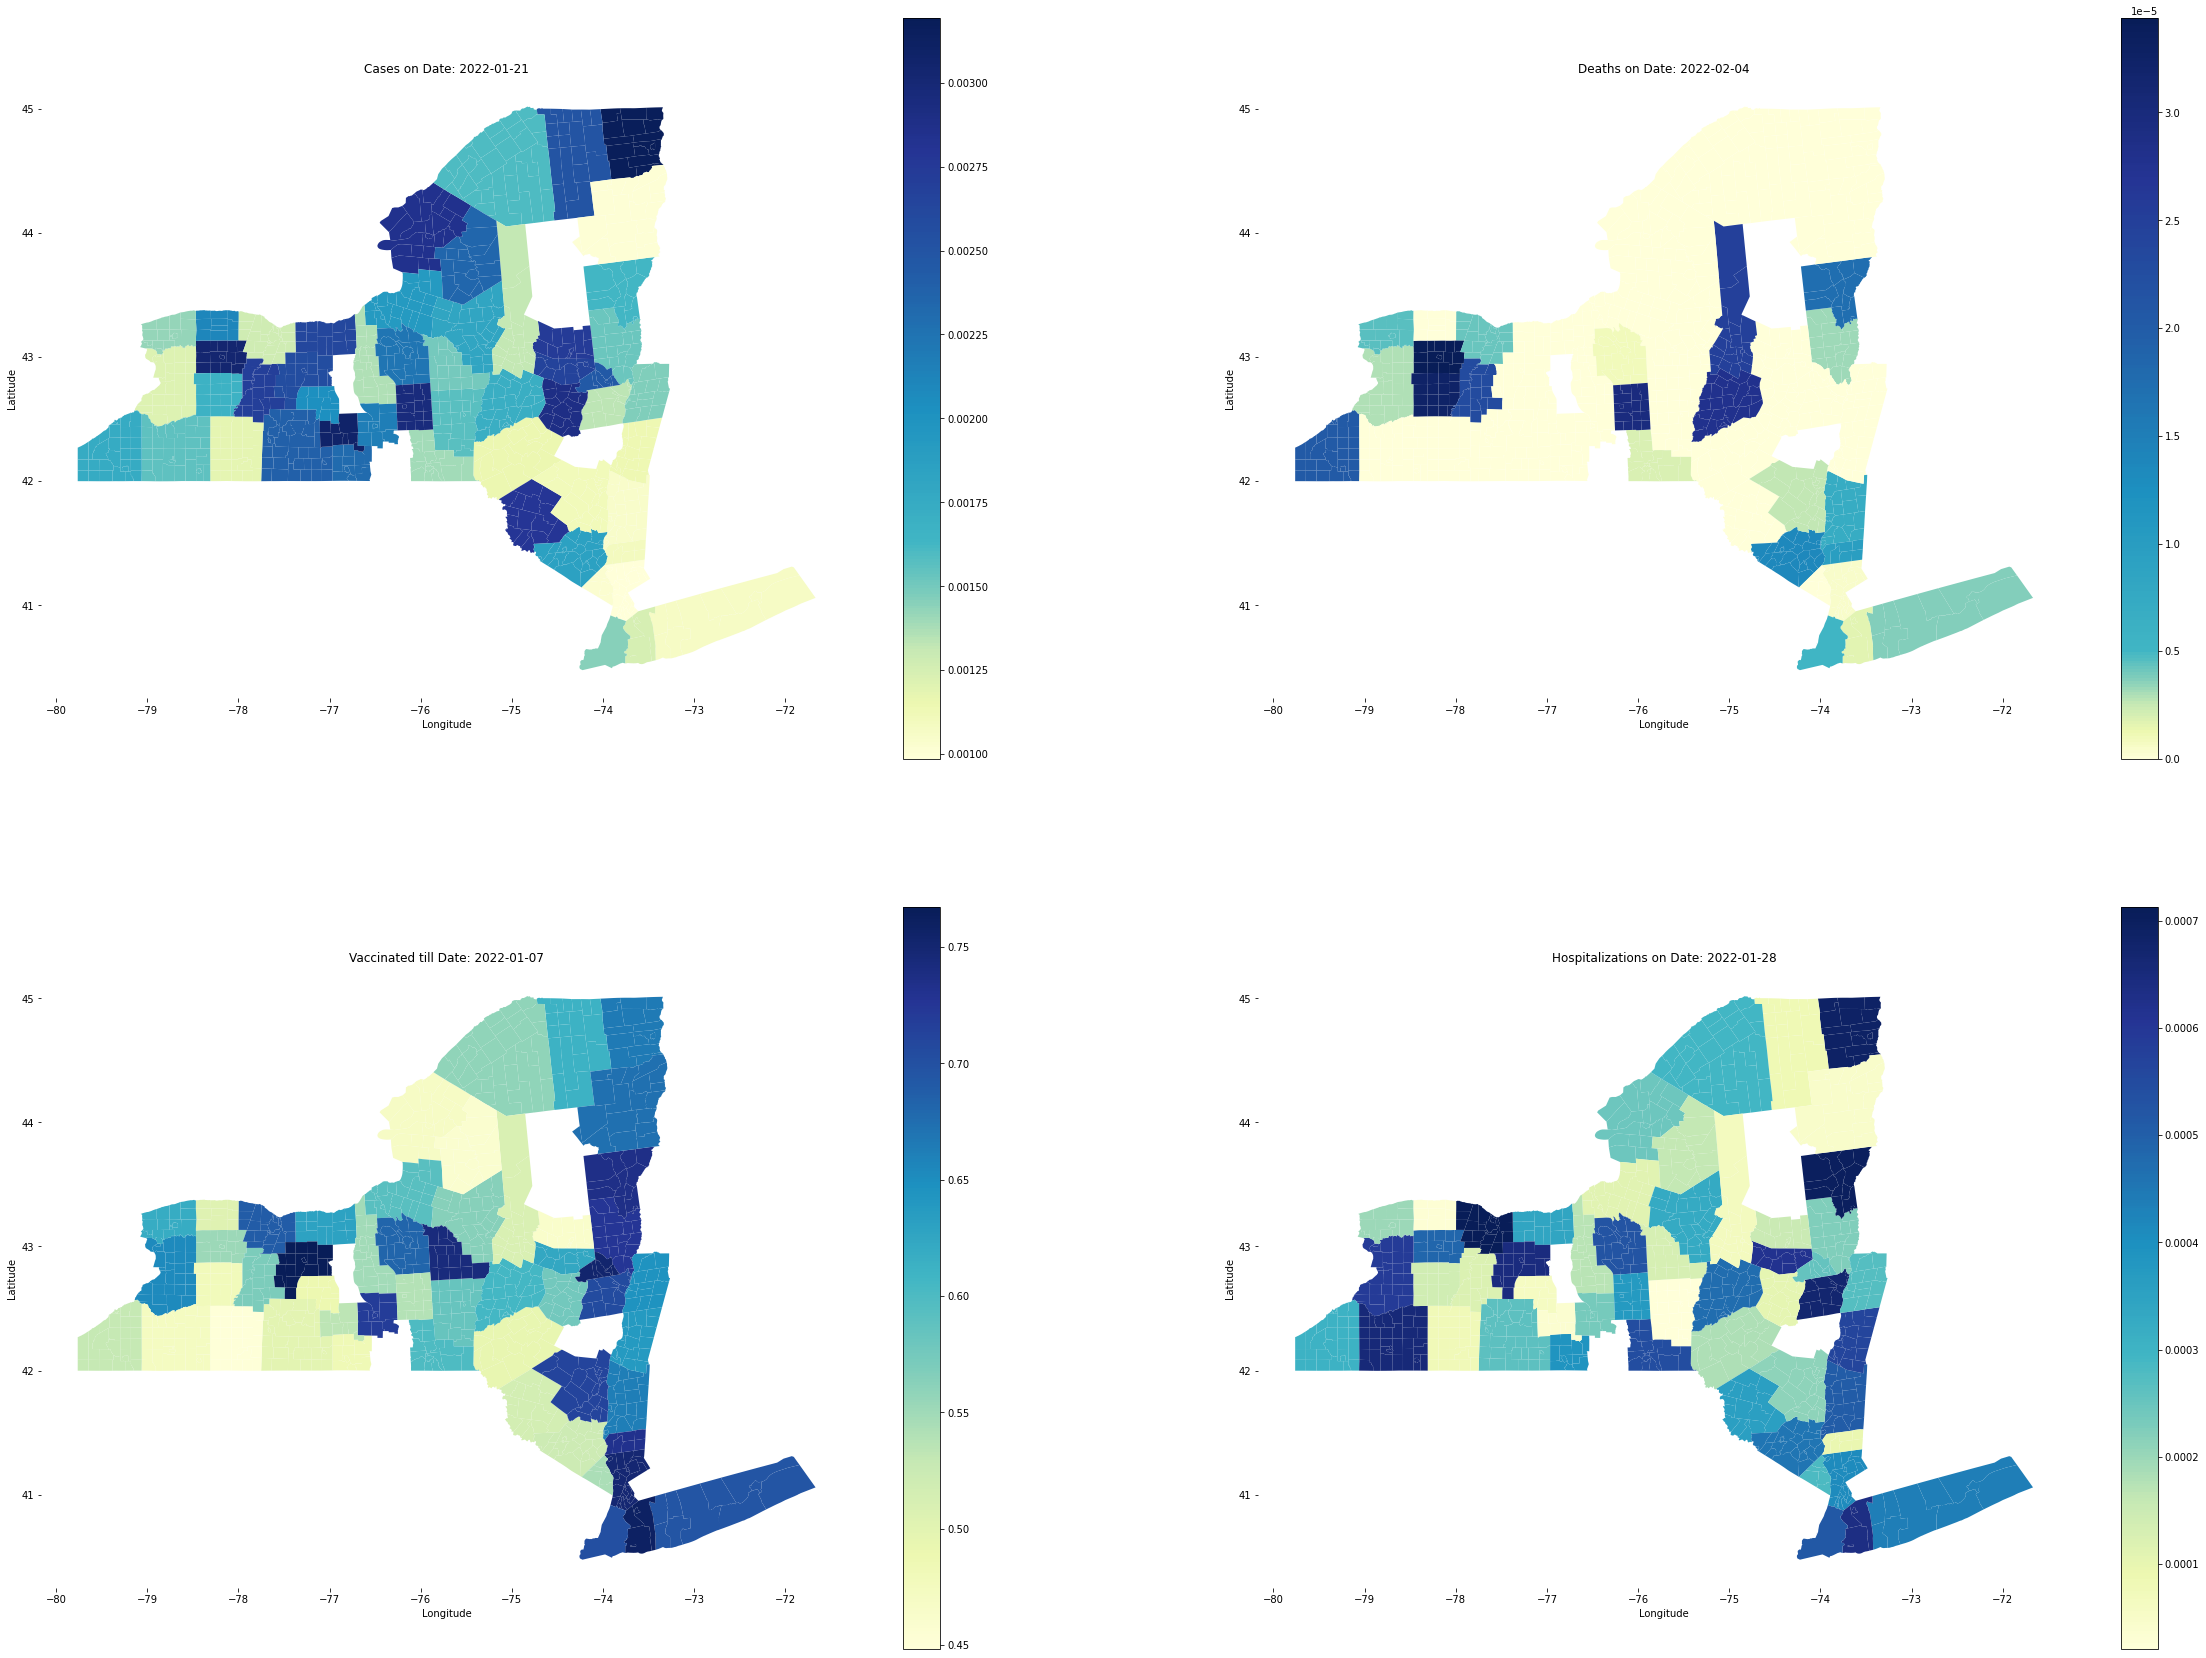

In [30]:
# Fifth wave - Omicron variant

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(40,30), ncols=2,nrows=2)

for date,ax in [('2022-01-21',ax1)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_cases_by_population', ax=ax, fig=fig, title="Cases on Date: "+date, show_base_cbar=True)

for date,ax in [('2022-02-04',ax2)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'daily_deaths_by_population', ax=ax, fig=fig, title="Deaths on Date: "+date, show_base_cbar=True)

for date,ax in [('2022-01-07',ax3)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'fully_vacc_by_pop', ax=ax, fig=fig, title="Vaccinated till Date: "+date, show_base_cbar=True)

for date,ax in [('2022-01-28',ax4)]:
    temp =  df[df.date == date]
    temp = street_map.merge(temp, on=['county'])
    plot_geo_data(temp, 'hosp_by_pop', ax=ax, fig=fig, title="Hospitalizations on Date: "+date, show_base_cbar=True)

**Conclusion:** There isn't any obvious general trend that we see between vaccination and cases/deaths/hospitalization. Each county follows its own pattern about how it reacts to vaccination.

# Were people actually following stringency policies?

We're comparing Mobility to Stringency Index to define this. Stringency Index talks about how strict policies were on a particular day. Mobility is divided into different categories such as, parks, grocery & pharmacy shops, retail & recreation etc.

In [31]:
stringency_data = pd.read_parquet(path+'processed_datasets/ny_stringency.parquet')

In [32]:
stringency_data = stringency_data.rename(columns={'Date':'date'})
stringency_data = stringency_data[(stringency_data['date'] > '2020-03-25') & (stringency_data['date'] < '2022-02-28')]
stringency_data.head()

,date,StringencyIndex
256063,2020-03-26,82.41
256064,2020-03-27,82.41
256065,2020-03-28,82.41
256066,2020-03-29,82.41
256067,2020-03-30,82.41


In [33]:
mobility = data[['county', 'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'daily_cases', 'daily_deaths', 'POP2020']]
mobility = mobility.drop_duplicates()
mobility['daily_cases_by_population'] = mobility.apply(lambda x: x['daily_cases']/x['POP2020'], axis=1)

In [34]:
mobility.head()

,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,daily_cases,daily_deaths,POP2020,daily_cases_by_population
0,Albany,2020-03-26,-51.0,-11.0,43.0,-53.0,-55.0,23.0,19.0,0.0,314848,0.000060
1,Suffolk,2020-03-26,-44.0,-14.0,122.0,-63.0,-53.0,24.0,475.0,2.0,1524665,0.000312
5,Jefferson,2020-03-26,-36.0,-10.0,-27.0,-15.0,-45.0,17.0,2.0,0.0,116721,0.000017
8,Herkimer,2020-03-26,-36.0,0.0,7.0,-38.0,-42.0,15.0,2.0,0.0,60139,0.000033
9,Genesee,2020-03-26,-40.0,-14.0,7.0,-41.0,-43.0,17.0,2.0,0.0,58147,0.000034


In [35]:
df_stringency = pd.merge(mobility, stringency_data, on='date', how='left')
df_stringency = df_stringency.drop(columns=['daily_cases', 'daily_deaths', 'POP2020'], axis=1)
df_stringency = df_stringency.drop_duplicates()

In [36]:
df_stringency.head()

,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,daily_cases_by_population,StringencyIndex
0,Albany,2020-03-26,-51.0,-11.0,43.0,-53.0,-55.0,23.0,0.000060,82.41
1,Suffolk,2020-03-26,-44.0,-14.0,122.0,-63.0,-53.0,24.0,0.000312,82.41
2,Jefferson,2020-03-26,-36.0,-10.0,-27.0,-15.0,-45.0,17.0,0.000017,82.41
3,Herkimer,2020-03-26,-36.0,0.0,7.0,-38.0,-42.0,15.0,0.000033,82.41
4,Genesee,2020-03-26,-40.0,-14.0,7.0,-41.0,-43.0,17.0,0.000034,82.41


In [37]:
# select top 5 counties with highest number of cases per population and plot the stringency vs mobility for those counties

county_df = df.groupby(['county']).sum()['daily_cases_by_population']
top5 = county_df.sort_values(ascending=False)[:5].index.to_list()
print(top5)

['Nassau', 'Suffolk', 'Orange', 'Rockland', 'New York, Bronx, Kings, Richmond, Queens']


In [38]:
# function to create plots for mobility with respect to stringency index

df_stringency = df_stringency.sort_values(by='date')

def plot_mobility(county, start_date, end_date):
  temp_df = df_stringency[df_stringency['county'] == county].reset_index()
  temp_df = temp_df[(temp_df['date']>=start_date) & (temp_df['date']<=end_date)].reset_index()
  temp_df = temp_df.sort_values(by='date')
  figure(figsize=(15, 6))
  plt.plot(temp_df['date'], temp_df['retail_and_recreation_percent_change_from_baseline'], label='Retail & Recreation')
  plt.plot(temp_df['date'], temp_df['grocery_and_pharmacy_percent_change_from_baseline'], label='Grocery & Pharmacy')
  plt.plot(temp_df['date'], temp_df['parks_percent_change_from_baseline'], label='Parks')
  plt.plot(temp_df['date'], temp_df['transit_stations_percent_change_from_baseline'], label='Transit Stations')
  plt.plot(temp_df['date'], temp_df['workplaces_percent_change_from_baseline'], label='Workplaces')
  plt.plot(temp_df['date'], temp_df['residential_percent_change_from_baseline'], label='Residential')
  plt.plot(temp_df['date'], temp_df['StringencyIndex'], label='Stringency Index')
  plt.xlabel('Date')
  plt.ylabel('Percentage change in Mobility')
  plt.title('Mobility Changes wrt Stringency Index for '+county)
  plt.legend()

In [40]:
# function to create plots for selected mobility categories, cases and stringency index

df_stringency = df_stringency.sort_values(by='date')

def plot_mobility_cases(county, start_date, end_date):
  temp_df = df_stringency[df_stringency['county'] == county].reset_index()
  temp_df = temp_df[(temp_df['date']>=start_date) & (temp_df['date']<=end_date)].reset_index()
  temp_df = temp_df.sort_values(by='date')
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(temp_df['date'], temp_df['retail_and_recreation_percent_change_from_baseline'], label='Retail & Recreation')
  ax.plot(temp_df['date'], temp_df['grocery_and_pharmacy_percent_change_from_baseline'], label='Grocery & Pharmacy')
  ax.plot(temp_df['date'], temp_df['transit_stations_percent_change_from_baseline'], label='Transit Stations')
  ax.plot(temp_df['date'], temp_df['StringencyIndex'], label='Stringency Index')
  ax2 = ax.twinx()
  ax2.plot(temp_df['date'], temp_df['daily_cases_by_population'], label='Cases', color='grey')
  ax2.set_ylabel('Cases', color='grey')
  ax.set_xlabel('Date')
  ax.set_ylabel('Percentage change in Mobility')
  plt.title('Mobility, Stringency, Cases trend for '+county)
  ax.legend()

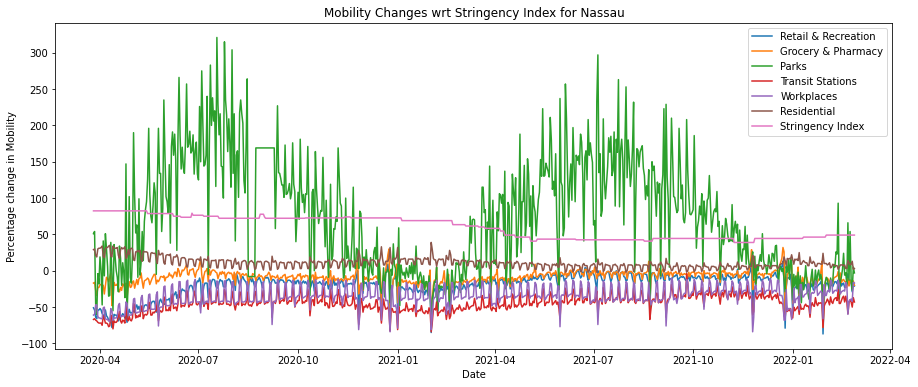

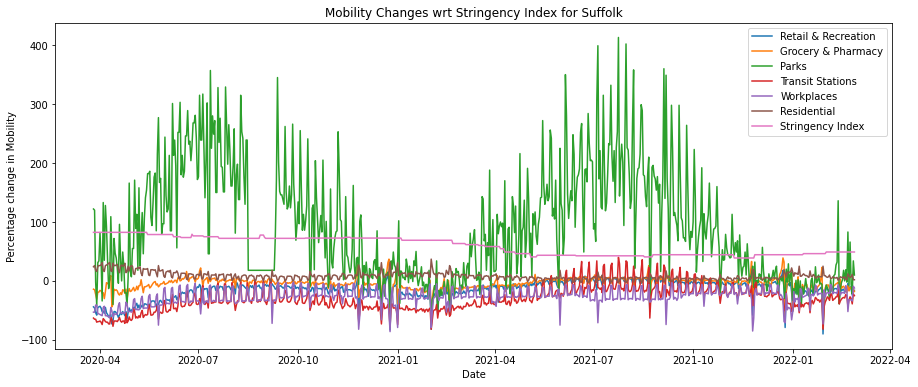

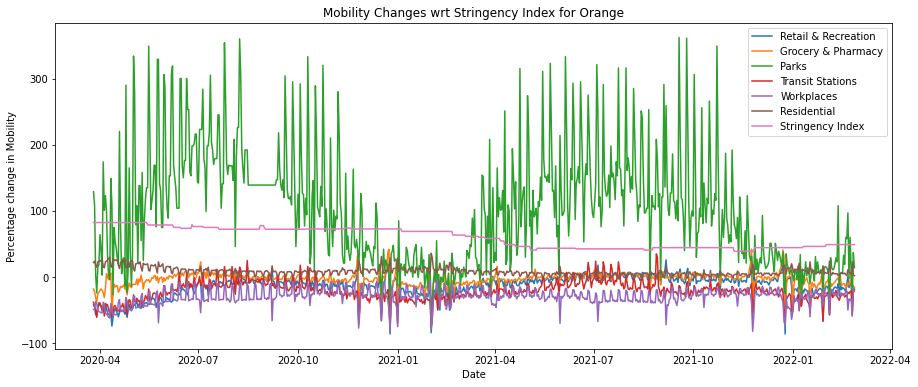

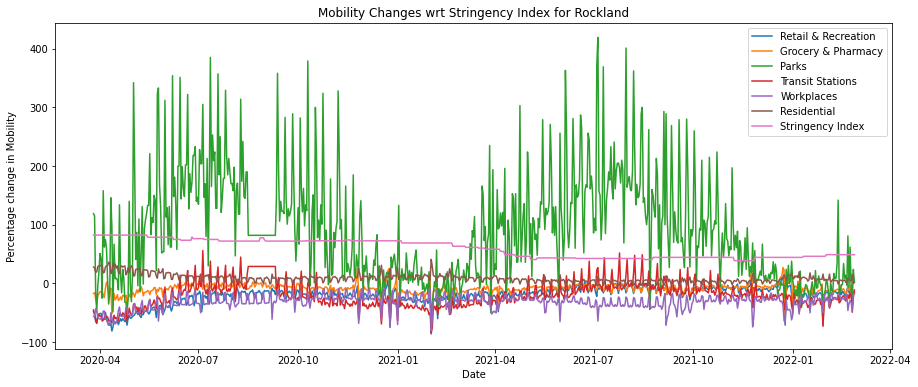

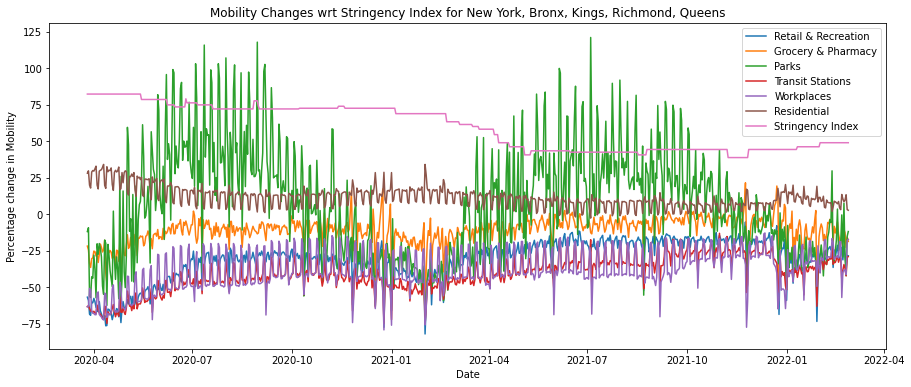

In [41]:
start_date = df_stringency['date'].min()
end_date = df_stringency['date'].max()

for county in top5:
  plot_mobility(county, start_date, end_date)

We do not see a pattern between mobility and stringency in these plots. So we will now look at specific waves and focus on only a few mobility categories. We will also add cases to this comparison.

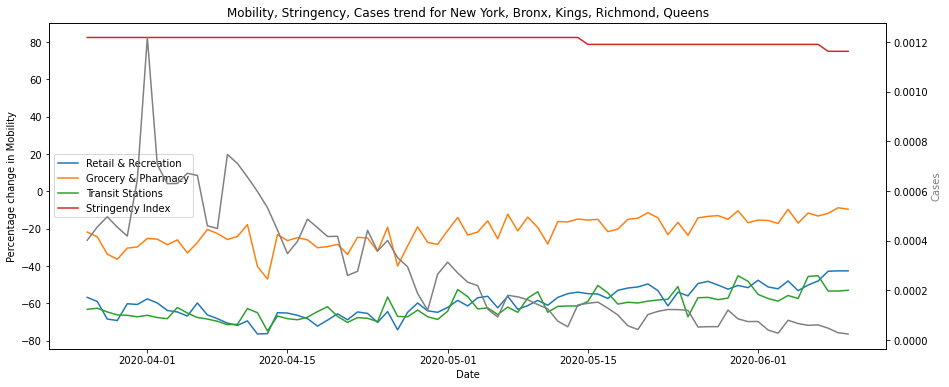

In [42]:
# Plot Mobility vs Stringency Index vs Cases for First Wave

plot_mobility_cases(county='New York, Bronx, Kings, Richmond, Queens', start_date='2020-03-16', end_date='2020-06-10')

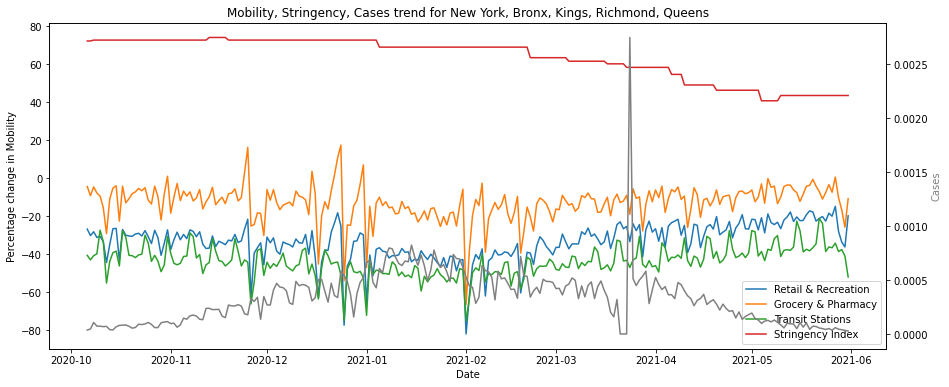

In [43]:
# Plot Mobility vs Stringency Index vs Cases for Second Wave

plot_mobility_cases(county='New York, Bronx, Kings, Richmond, Queens', start_date='2020-10-06', end_date='2021-05-31')

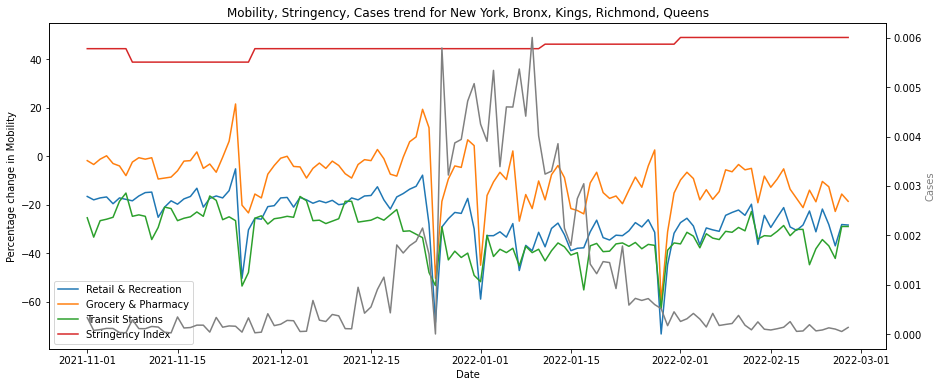

In [44]:
# Plot Mobility vs Stringency Index vs Cases for Third Wave

plot_mobility_cases(county='New York, Bronx, Kings, Richmond, Queens', start_date='2021-11-01', end_date='2022-03-06')

**Conclusion:** We don't see a trend between cases and mobility. However, we notice a slight correlation between stringency and mobility.

# Effect of Stringency on Cases

In [45]:
cases_df = df[['date', 'county', 'daily_cases_by_population']]

cases_stringency = pd.merge(cases_df, stringency_data, on='date', how='left')

In [46]:
cases_stringency.head()

,date,county,daily_cases_by_population,StringencyIndex
0,2020-03-26,Albany,0.000060,82.41
1,2020-03-27,Albany,0.000051,82.41
2,2020-03-28,Albany,0.000025,82.41
3,2020-03-29,Albany,0.000032,82.41
4,2020-03-30,Albany,0.000038,82.41


Text(0.5, 1.0, 'Cases wrt Stringency Index for Albany')

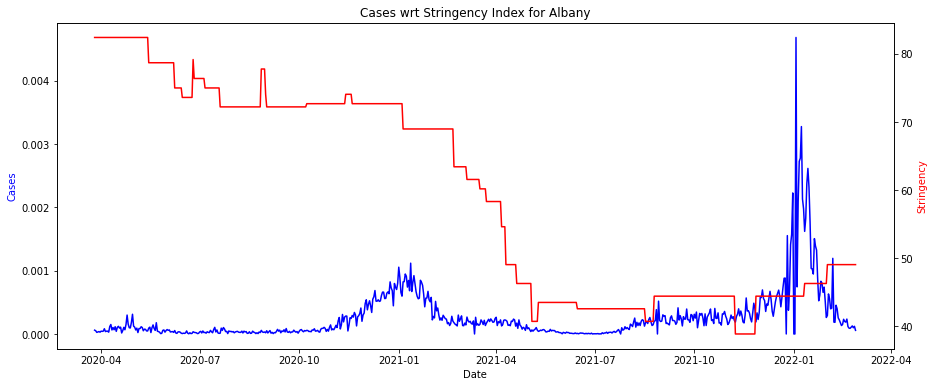

In [47]:
county = 'Albany'
temp_df = cases_stringency[cases_stringency['county']==county]
temp_df = temp_df.sort_values(by='date')

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(temp_df['date'], temp_df['daily_cases_by_population'], label='Cases', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Cases', color='blue')
ax2=ax.twinx()
ax2.plot(temp_df['date'], temp_df['StringencyIndex'], label='StringencyIndex', color='red')
ax2.set_ylabel('Stringency', color='red')
plt.title('Cases wrt Stringency Index for '+county)

Text(0.5, 1.0, 'Cases wrt Stringency Index for New York, Bronx, Kings, Richmond, Queens')

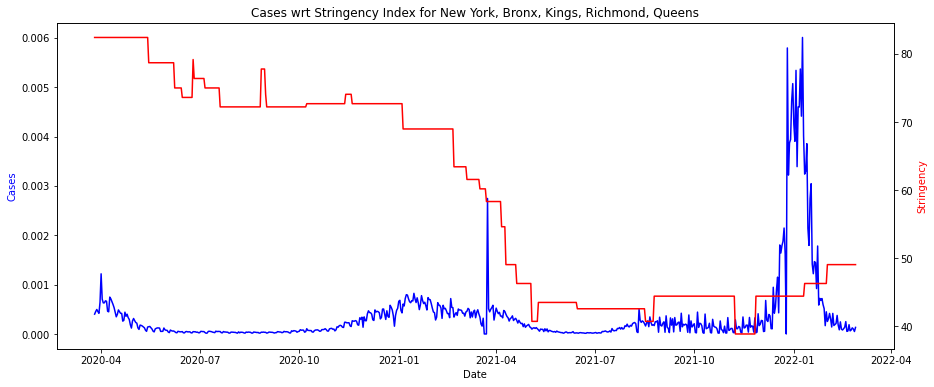

In [48]:
county = 'New York, Bronx, Kings, Richmond, Queens'
temp_df = cases_stringency[cases_stringency['county']==county]
temp_df = temp_df.sort_values(by='date')

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(temp_df['date'], temp_df['daily_cases_by_population'], label='Cases', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Cases', color='blue')
ax2=ax.twinx()
ax2.plot(temp_df['date'], temp_df['StringencyIndex'], label='StringencyIndex', color='red')
ax2.set_ylabel('Stringency', color='red')
plt.title('Cases wrt Stringency Index for '+county)

**Conclusion:** We notice that when COVID seemed to have stabilized, policies were made lesser stringent. But with that, cases increased again. So with decrease in stringency index, cases tend to increase.